## Feature Selection |Correlation-based feature removal | Random Forest Feature Importance | Mutual Information | 

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split # Mặc dù đã split, nhưng có thể dùng lại cho các bước sau nếu cần
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


df_train = pd.read_csv('../Data/FE_reviews_train.csv')
df_test = pd.read_csv('../Data/FE_reviews_test.csv')


# Kiểm tra dữ liệu đã nạp
print("Shape of df_train:", df_train.shape)
print("Shape of df_test_:", df_test.shape)


df_train.head()


Shape of df_train: (15454, 37)
Shape of df_test_: (3874, 37)


,clothing_id,age,title,review_text,rating,positive_feedback_count,recommended_ind,cleaned_review_text,positive_feedback_count_capped,review_length,...,class_name_Lounge,class_name_Outerwear,class_name_Pants,class_name_Shorts,class_name_Skirts,class_name_Sleep,class_name_Sweaters,class_name_Swim,class_name_Trend,sentiment_score
0,1095,26,Proceed with caution if you are busty!,I absolutely love this dress! it's a great sum...,5,3,1,absolutely love dress great summer dress thats...,3.0,54,...,False,False,False,False,False,False,False,False,False,0.9763
1,850,52,"Love, love, love this tunic!",Perfect little summer tunic that is very flatt...,5,1,1,perfect little summer tunic flattering paired ...,1.0,29,...,False,False,False,False,False,False,False,False,False,0.8942
2,971,27,What happened!,I have never had a purchase go wrong at retail...,1,3,0,never purchase go wrong retailer hesitant spen...,3.0,35,...,False,False,False,False,False,False,False,False,False,0.8383
3,854,37,Nice white top,Beautiful white top. peplum never looged good ...,4,0,1,beautiful white top peplum never looged good f...,0.0,32,...,False,False,False,False,False,False,False,False,False,0.4773
4,867,30,Gorgeous,"I bought this on a whim, and i love it. the co...",5,1,1,bought whim love color much brighter photo wou...,1.0,21,...,False,False,False,False,False,False,False,False,False,0.9451


In [2]:
# Split features (X) and target (y)
X_train_df = df_train.drop(columns=['recommended_ind'])
y_train = df_train['recommended_ind']

X_test_df = df_test.drop(columns=['recommended_ind'])
y_test = df_test['recommended_ind']

# Process the text column
text_column = 'cleaned_review_text'
X_train_df[text_column] = X_train_df[text_column].fillna("")
X_test_df[text_column] = X_test_df[text_column].fillna("")

In [3]:
# ALl columns in the training set
all_cols = X_train_df.columns.tolist()

# Identify numeric columns
non_numeric_structured_cols = [text_column, 'clothing_id', 'title'] 
if 'Unnamed: 0' in all_cols: 
    non_numeric_structured_cols.append('Unnamed: 0')


In [4]:
# Identify numeric columns that need scaling
numeric_cols_to_scale = ['age', 'positive_feedback_count', 'review_length', 'sentiment_score']
# Ensure these columns exist in X_train_df and X_test_df
numeric_cols_to_scale = [col for col in numeric_cols_to_scale if col in X_train_df.columns]

# Identify one-hot encoded columns
one_hot_cols = [col for col in all_cols if col not in non_numeric_structured_cols + numeric_cols_to_scale]

print(f"Numeric columns to scale: {numeric_cols_to_scale}")
print(f"One-hot encoded columns: {one_hot_cols}")

Numeric columns to scale: ['age', 'positive_feedback_count', 'review_length', 'sentiment_score']
One-hot encoded columns: ['review_text', 'rating', 'positive_feedback_count_capped', 'division_name_General Petite', 'division_name_Initmates', 'department_name_Dresses', 'department_name_Intimate', 'department_name_Jackets', 'department_name_Tops', 'department_name_Trend', 'class_name_Casual bottoms', 'class_name_Chemises', 'class_name_Dresses', 'class_name_Fine gauge', 'class_name_Intimates', 'class_name_Jackets', 'class_name_Jeans', 'class_name_Knits', 'class_name_Layering', 'class_name_Legwear', 'class_name_Lounge', 'class_name_Outerwear', 'class_name_Pants', 'class_name_Shorts', 'class_name_Skirts', 'class_name_Sleep', 'class_name_Sweaters', 'class_name_Swim', 'class_name_Trend']


In [5]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled_numeric = scaler.fit_transform(X_train_df[numeric_cols_to_scale])
# Transform the test data using the already fitted scaler
X_test_scaled_numeric = scaler.transform(X_test_df[numeric_cols_to_scale])

# Convert back to DataFrame for easier management (optional but useful)
X_train_scaled_numeric_df = pd.DataFrame(X_train_scaled_numeric, columns=numeric_cols_to_scale, index=X_train_df.index)
X_test_scaled_numeric_df = pd.DataFrame(X_test_scaled_numeric, columns=numeric_cols_to_scale, index=X_test_df.index)

In [6]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000) 

# Fit TF-IDF on the training data and transform it
X_train_tfidf = tfidf.fit_transform(X_train_df[text_column])
# Transform the test data using the already fitted TF-IDF
X_test_tfidf = tfidf.transform(X_test_df[text_column])

In [7]:
X_train_one_hot_df = X_train_df[one_hot_cols].copy()
X_test_one_hot_df = X_test_df[one_hot_cols].copy()

# Ensure all columns in one-hot encoded DataFrames are numeric
X_train_one_hot_df = X_train_one_hot_df.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test_one_hot_df = X_test_one_hot_df.apply(pd.to_numeric, errors='coerce').fillna(0)

### Correlation-based Feature Removal

In [8]:
# Combine scaled numeric features and one-hot encoded features for training
X_train_structured_combined_df = pd.concat(
    [X_train_scaled_numeric_df, X_train_one_hot_df.reset_index(drop=True)], 
    axis=1
)

# Compute the absolute correlation matrix
corr_matrix_train = X_train_structured_combined_df.corr().abs()

# Extract the upper triangle of the correlation matrix to avoid duplicate pairs
upper_triangle_train = corr_matrix_train.where(
    np.triu(np.ones(corr_matrix_train.shape), k=1).astype(bool)
)

# Identify features with high correlation above a threshold (e.g., 0.85)
correlation_threshold = 0.85
to_drop_structured_train = [column for column in upper_triangle_train.columns if any(upper_triangle_train[column] > correlation_threshold)]

print(f"Structured features to be dropped due to high correlation (> {correlation_threshold}): {to_drop_structured_train}")

# Drop these features from both training and testing structured datasets
X_train_structured_selected_df = X_train_structured_combined_df.drop(columns=to_drop_structured_train)

X_test_structured_combined_df = pd.concat(
    [X_test_scaled_numeric_df, X_test_one_hot_df.reset_index(drop=True)], 
    axis=1
)
X_test_structured_selected_df = X_test_structured_combined_df.drop(columns=to_drop_structured_train)

print(f"Structured feature dimensions after correlation removal (train): {X_train_structured_selected_df.shape}")
print(f"Structured feature dimensions after correlation removal (test): {X_test_structured_selected_df.shape}")

# Get the list of remaining structured feature names
remaining_structured_feature_names = X_train_structured_selected_df.columns.tolist()


Structured features to be dropped due to high correlation (> 0.85): ['department_name_Intimate', 'class_name_Dresses', 'class_name_Trend']
Structured feature dimensions after correlation removal (train): (15454, 30)
Structured feature dimensions after correlation removal (test): (3874, 30)


In [9]:
# Ensure all columns in structured DataFrames are numeric
X_train_structured_selected_df = X_train_structured_selected_df.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test_structured_selected_df = X_test_structured_selected_df.apply(pd.to_numeric, errors='coerce').fillna(0)

X_train_combined = hstack([
    X_train_structured_selected_df.to_numpy(dtype=np.float64),  
    X_train_tfidf
])

X_test_combined = hstack([
    X_test_structured_selected_df.to_numpy(dtype=np.float64),
    X_test_tfidf
])

print(f"Combined data size (training): {X_train_combined.shape}")
print(f"Combined data size (testing): {X_test_combined.shape}")

combined_feature_names = numeric_cols_to_scale + one_hot_cols + tfidf.get_feature_names_out().tolist()
print(f"Total number of combined features: {len(combined_feature_names)}")


Combined data size (training): (15454, 5030)
Combined data size (testing): (3874, 5030)
Total number of combined features: 5033


## Model Building/Training

### Random Forest

In [10]:
rf_selector_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # Thêm class_weight
rf_selector_model.fit(X_train_combined, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [11]:
importances = rf_selector_model.feature_importances_
N_rf = 300  
rf_indices = np.argsort(importances)[-N_rf:]  

# Create new datasets with features selected by Random Forest
X_train_combined_csr = X_train_combined.tocsr()
X_test_combined_csr = X_test_combined.tocsr()

X_train_rf_selected = X_train_combined_csr[:, rf_indices]
X_test_rf_selected = X_test_combined_csr[:, rf_indices]  

print(f"Data size after selection using RF Importance (train): {X_train_rf_selected.shape}")
print(f"Data size after selection using RF Importance (test): {X_test_rf_selected.shape}")


Data size after selection using RF Importance (train): (15454, 300)
Data size after selection using RF Importance (test): (3874, 300)


### Mutual Information

In [12]:
K_mi = 300 
mi_selector = SelectKBest(mutual_info_classif, k=K_mi)
X_train_mi_selected = mi_selector.fit_transform(X_train_combined, y_train)
X_test_mi_selected = mi_selector.transform(X_test_combined)  # Apply the same transformation to the test set

print(f"Data size after selection using Mutual Information (train): {X_train_mi_selected.shape}")  
print(f"Data size after selection using Mutual Information (test): {X_test_mi_selected.shape}")

# Retrieve the names of features selected by MI (if needed)
mi_indices = mi_selector.get_support(indices=True)
mi_selected_feature_names = [combined_feature_names[i] for i in mi_indices]
print(f"A few features selected by MI: {mi_selected_feature_names[:10]}")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering m

Data size after selection using Mutual Information (train): (15454, 300)
Data size after selection using Mutual Information (test): (3874, 300)
A few features selected by MI: ['sentiment_score', 'rating', 'abby', 'abou', 'activewear', 'actually', 'admit', 'age', 'apron', 'ar']


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering m

In [13]:
#--- Model with Features from Random Forest Importance ---
# Model parameters
rf_model_on_rf_features = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_on_rf_features.fit(X_train_rf_selected, y_train)

# Predictions
y_pred_rf = rf_model_on_rf_features.predict(X_test_rf_selected)
y_proba_rf = rf_model_on_rf_features.predict_proba(X_test_rf_selected)[:, 1]

# Evaluation
print("Results for the Model with Features Selected by Random Forest:")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")


Results for the Model with Features Selected by Random Forest:
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       691
           1       0.98      0.95      0.97      3183

    accuracy                           0.95      3874
   macro avg       0.90      0.94      0.92      3874
weighted avg       0.95      0.95      0.95      3874

ROC AUC Score: 0.9894


In [14]:
#--- Model with Features from Mutual Information ---

# Model parameters
rf_model_on_mi_features = RandomForestClassifier(n_estimators=100, random_state=42) 
rf_model_on_mi_features.fit(X_train_mi_selected, y_train)

# Predictions
y_pred_mi = rf_model_on_mi_features.predict(X_test_mi_selected)
y_proba_mi = rf_model_on_mi_features.predict_proba(X_test_mi_selected)[:, 1]

# Evaluation
print("Results for the Model with Features Selected by Mutual Information:")
print("Classification Report:\n", classification_report(y_test, y_pred_mi))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_mi):.4f}")

Results for the Model with Features Selected by Mutual Information:
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87       691
           1       0.98      0.96      0.97      3183

    accuracy                           0.95      3874
   macro avg       0.91      0.94      0.92      3874
weighted avg       0.95      0.95      0.95      3874

ROC AUC Score: 0.9891


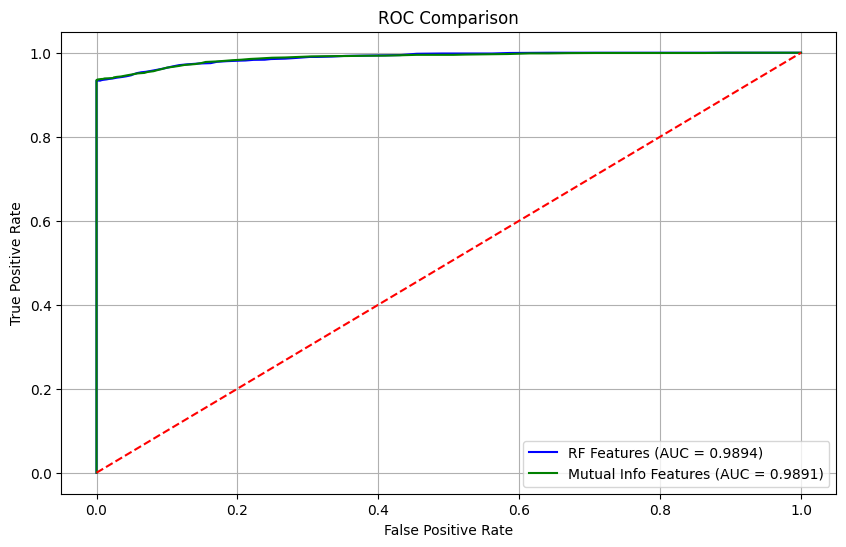

In [15]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf) # 
roc_auc_rf_val = auc(fpr_rf, tpr_rf) # 

fpr_mi, tpr_mi, _ = roc_curve(y_test, y_proba_mi) # 
roc_auc_mi_val = auc(fpr_mi, tpr_mi) # 

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'RF Features (AUC = {roc_auc_rf_val:.4f})') # 
plt.plot(fpr_mi, tpr_mi, color='green', label=f'Mutual Info Features (AUC = {roc_auc_mi_val:.4f})') # 
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Comparison') 
plt.legend(loc='lower right') # 
plt.grid(True) 
plt.show() 

In [16]:
# Retrieve importances from the model trained on the selected features
final_model_importances = rf_model_on_rf_features.feature_importances_


rf_selected_original_names = [combined_feature_names[i] for i in rf_indices]

feature_importances_df = pd.DataFrame({
    'Feature_Original_Name': rf_selected_original_names, 
    'Importance': final_model_importances
})

# Sorting
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importances_df.head(10)) # 



Top 10 Feature Importances:
    Feature_Original_Name  Importance
299                rating    0.474749
298       sentiment_score    0.049566
293              disagree    0.010656
292           longwaisted    0.009698
287                   age    0.008576
290         review_length    0.008326
275                 retro    0.007975
277              retuning    0.007927
289                wallet    0.007758
281                 hubby    0.007309


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]  
}

print("\n--- Starting Hyperparameter Optimization for RF model (on RF selected features) ---")
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=param_grid,
                              cv=3, 
                              scoring='roc_auc',  
                              verbose=2,
                              n_jobs=-1) 

grid_search_rf.fit(X_train_rf_selected, y_train)

print(f"Best parameters found: {grid_search_rf.best_params_}")
print(f"Best ROC AUC on validation set (cross-validated): {grid_search_rf.best_score_:.4f}")

# Train the final model with the best parameters
best_rf_model = grid_search_rf.best_estimator_



--- Starting Hyperparameter Optimization for RF model (on RF selected features) ---
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.4s
[CV] END max_depth=None, min

In [21]:
best_rf_model = grid_search_rf.best_estimator_

best_rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=10,
    random_state=42
)
best_rf_model.fit(X_train_rf_selected, y_train) 

RandomForestClassifier(min_samples_split=10, n_estimators=300, random_state=42)


Results for the BEST RF Model (after tuning) on the Test Set:
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       691
           1       0.98      0.96      0.97      3183

    accuracy                           0.95      3874
   macro avg       0.91      0.94      0.92      3874
weighted avg       0.96      0.95      0.95      3874

ROC AUC Score on the Test Set: 0.9899


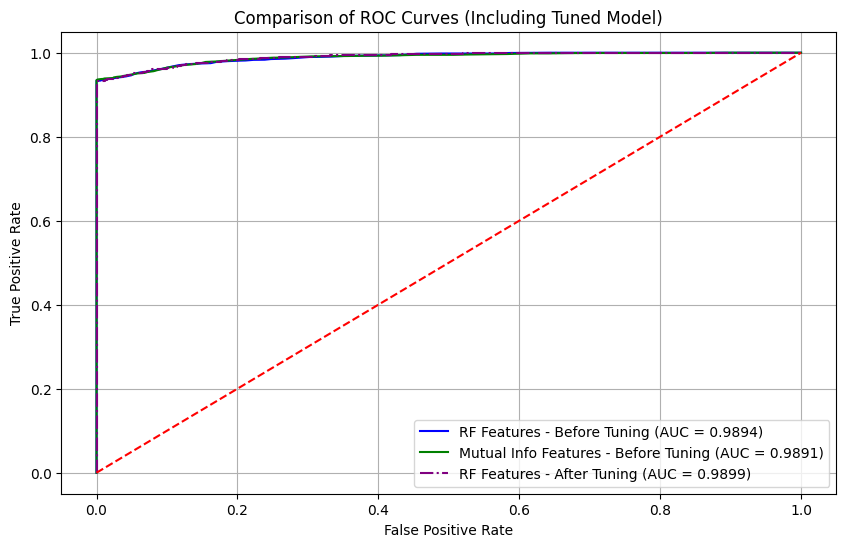

In [22]:
# Predict on the test set
y_pred_best_rf = best_rf_model.predict(X_test_rf_selected)
y_proba_best_rf = best_rf_model.predict_proba(X_test_rf_selected)[:, 1]

# Evaluate
print("\nResults for the BEST RF Model (after tuning) on the Test Set:")
print("Classification Report:\n", classification_report(y_test, y_pred_best_rf))
print(f"ROC AUC Score on the Test Set: {roc_auc_score(y_test, y_proba_best_rf):.4f}")

# Plot the ROC curve again if you want to compare with previous models
fpr_best_rf, tpr_best_rf, _ = roc_curve(y_test, y_proba_best_rf)
roc_auc_best_rf_val = auc(fpr_best_rf, tpr_best_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'RF Features - Before Tuning (AUC = {roc_auc_rf_val:.4f})') # If you have the old value
plt.plot(fpr_mi, tpr_mi, color='green', label=f'Mutual Info Features - Before Tuning (AUC = {roc_auc_mi_val:.4f})') # If available
plt.plot(fpr_best_rf, tpr_best_rf, color='purple', linestyle='-.', label=f'RF Features - After Tuning (AUC = {roc_auc_best_rf_val:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves (Including Tuned Model)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       691
           1       0.98      0.96      0.97      3183

    accuracy                           0.95      3874
   macro avg       0.91      0.94      0.92      3874
weighted avg       0.96      0.95      0.95      3874

ROC AUC Score (Test Set): 0.9899


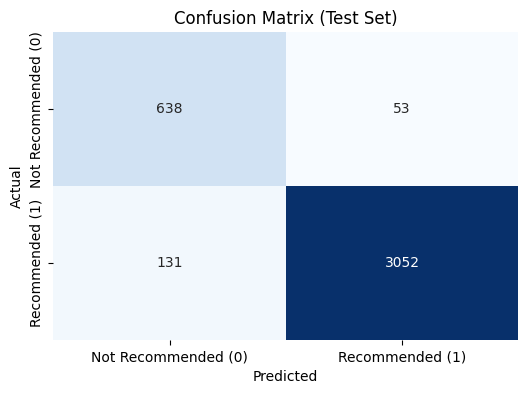

ROC AUC on validation set (cross-validated): 0.9900
ROC AUC on test set: 0.9899
Performance on the test set is similar to the validation set. The model generalizes well!


In [23]:
# Perform Predictions on the Test Set
y_pred_test = best_rf_model.predict(X_test_rf_selected)
y_proba_test = best_rf_model.predict_proba(X_test_rf_selected)[:, 1]

# Evaluate Performance on the Test Set
print("Classification Report (Test Set):\n", classification_report(y_test, y_pred_test))
roc_auc_test = roc_auc_score(y_test, y_proba_test)
print(f"ROC AUC Score (Test Set): {roc_auc_test:.4f}")

# Plot ROC Curve for the Test Set
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Recommended (0)', 'Recommended (1)'],
            yticklabels=['Not Recommended (0)', 'Recommended (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# 5. Compare and Analyze
print(f"ROC AUC on validation set (cross-validated): {grid_search_rf.best_score_:.4f}") # From GridSearchCV
print(f"ROC AUC on test set: {roc_auc_test:.4f}")
if np.isclose(grid_search_rf.best_score_, roc_auc_test, atol=0.01): # atol is the allowed tolerance
    print("Performance on the test set is similar to the validation set. The model generalizes well!")
elif roc_auc_test < grid_search_rf.best_score_:
    print("WARNING: Performance on the test set is significantly lower than the validation set. This may indicate overfitting.")    
else:
    print("Performance on the test set is even better than the validation set (rare but possible).")
